## Chapter 20. Natural Language Processing

***NLP*** = computational techniques involving language = (v. broad field)

### Word Clouds

These artistically lay out words w/ sizes proportional to frequency, although sort of pointless as placement of words doesn’t mean anything. **If forced to create a word cloud, think about whether you can make the axes convey something**. 

For example, imagine, for each of some collection of data science–related buzzwords, you have 2 #'s between 0-100, the 1st representing how frequently it appears in job postings, the second how frequently it appears on resumes:

In [1]:
data = [ ("big data", 100, 15), ("Hadoop", 95, 25), ("Python", 75, 50),
        ("R", 50, 40), ("machine learning", 80, 20), ("statistics", 20, 60),
        ("data science", 60, 70), ("analytics", 90, 3),
        ("team player", 85, 85), ("dynamic", 2, 90), ("synergies", 70, 0),
        ("actionable insights", 40, 30), ("think out of the box", 45, 10),
        ("self-starter", 30, 50), ("customer focus", 65, 15),
        ("thought leadership", 35, 35)]

Word cloud just arranges the words on a page in a cool-looking font that looks neat but doesn’t really tell us anything. A more interesting approach might be
to *scatter* them so horizontal position = posting popularity + vertical position = resume popularity, which produces a viz that conveys a few insights

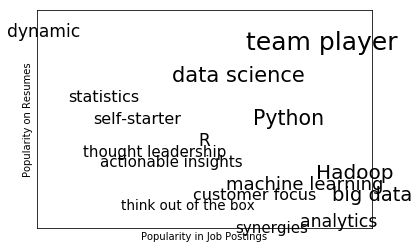

In [2]:
%matplotlib inline

from matplotlib import pyplot as plt

def text_size(total):
    """Equals 8 if total = 0, equals 28 if total = 200"""
    return 8 + total / 200 * 20

for word, job_popularity, resume_popularity in data:
    plt.text(job_popularity,resume_popularity,word,ha="center",va="center",
            size=text_size(job_popularity+resume_popularity))
plt.xlabel("Popularity in Job Postings")
plt.ylabel("Popularity on Resumes")
plt.axis([0,100,0,100])
plt.xticks([])
plt.yticks([])
plt.show()

### n-gram Models

VP of Search Engine Marketing wants to create thousands of web pages about data science so the site will rank higher in search results for data
science–related terms. She doesn’t want to write thousands of web pages, nor pay a horde of “content strategists” to do so. Instead, must somehow
programatically generate these web pages via some way of modeling language.

1 approach = start w/ a corpus of documents + learn a statistical model of
language. In our case, start with Mike Loukides’s essay [“What is data science?”](https://www.oreilly.com/ideas/what-is-data-science), using `requests` + `BeautifulSoup` to retrieve the data. 

Couple of issues worth calling attention to.

* apostrophes in the text = actually the Unicode character u"\u2019" =  create a helper function to replace them with normal apostrophes
* once we get the text of the web page, split it into a sequence of words + periods (so we can tell where sentences end) via `re.findall()`

In [3]:
import requests
import re
from bs4 import BeautifulSoup

def fix_unicode(text):
    return text.replace(u"\u2019","'")

url = "http://radar.oreilly.com/2010/06/what-is-data-science.html"
html = requests.get(url).text
soup = BeautifulSoup(html,"html5lib")

content = soup.find("div","article-body") # find entry content div
regex = r"[\w]+|[\.]" # match either a word or period
print(content)

<div class="article-body" itemprop="articleBody">
        
                              <figure class="article-image right">
  <img alt="Maps are data made into a product." class="" sizes="(min-width: 1390px) 420px, (min-width: 600px) 45vw, 100vw" src="https://d3tdunqjn7n0wj.cloudfront.net/360x240/newyorkmap-2000px-1fc039cc202929cb0c938c12f512acec.jpg" srcset="https://d3tdunqjn7n0wj.cloudfront.net/360x240/newyorkmap-2000px-1fc039cc202929cb0c938c12f512acec.jpg 360w, https://d3tdunqjn7n0wj.cloudfront.net/720x480/newyorkmap-2000px-1fc039cc202929cb0c938c12f512acec.jpg 720w, https://d3tdunqjn7n0wj.cloudfront.net/1440x960/newyorkmap-2000px-1fc039cc202929cb0c938c12f512acec.jpg 1440w"/>
  <figcaption>Maps are data made into a product.
          <span class="source-name">
                  (source: <a class="secondary" href="http://publicdomainreview.org/collections/highlights-from-the-20000-maps-made-freely-available-online-by-new-york-public-library/" target="_blank">New York Public Library<

In [4]:
document = []

for paragraph in content("p"):
    words = re.findall(regex,fix_unicode(paragraph.text))
    document.extend(words)
    
print(document)

['We', 've', 'all', 'heard', 'it', 'according', 'to', 'Hal', 'Varian', 'statistics', 'is', 'the', 'next', 'sexy', 'job', '.', 'Five', 'years', 'ago', 'in', 'What', 'is', 'Web', '2', '.', '0', 'Tim', 'O', 'Reilly', 'said', 'that', 'data', 'is', 'the', 'next', 'Intel', 'Inside', '.', 'But', 'what', 'does', 'that', 'statement', 'mean', 'Why', 'do', 'we', 'suddenly', 'care', 'about', 'statistics', 'and', 'about', 'data', 'In', 'this', 'post', 'I', 'examine', 'the', 'many', 'sides', 'of', 'data', 'science', 'the', 'technologies', 'the', 'companies', 'and', 'the', 'unique', 'skill', 'sets', '.', 'The', 'web', 'is', 'full', 'of', 'data', 'driven', 'apps', '.', 'Almost', 'any', 'e', 'commerce', 'application', 'is', 'a', 'data', 'driven', 'application', '.', 'There', 's', 'a', 'database', 'behind', 'a', 'web', 'front', 'end', 'and', 'middleware', 'that', 'talks', 'to', 'a', 'number', 'of', 'other', 'databases', 'and', 'data', 'services', 'credit', 'card', 'processing', 'companies', 'banks', 'an

Certainly could (+ likely should) clean this data further. There is still some amount of extraneous text in the doc (ex: “Section”), we’ve split on midsentence periods (ex; “Web 2.0”), + there's are a handful of captions + lists sprinkled throughout. Having said that, we’ll work w/ the doc it is.

Now that we have the text as a sequence of words, can model language in the
following way: 

* given some starting word, look @ all words that follow it in the source doc 
* randomly choose 1 of these to be the next word
* repeat process until we get to a period = signifies end of sentence.

This = a **bigram model** = is determined completely by frequencies of **bigrams (word pairs)** in the original data. For a starting word, just pick randomly from words that follow a period.

To start, precompute the possible word transitions (Recall `zip` stops when any of its inputs is done, so that `zip(document, document[1:])` gives us precisely the pairs of consecutive elements of document:

In [5]:
from collections import defaultdict

bigrams = zip(document,document[1:])
transitions = defaultdict(list)
for prev,current in bigrams:
    transitions[prev].append(current)
    
#print(bigrams,"\n")
#print(transitions.keys())

Now generate sentences

In [6]:
import random

def generate_using_bigrams():
    current = "." # next word starts a sentence
    result = []
    while True:
        next_word_candidates = transitions[current] # bigrams(current, _)
        current = random.choice(next_word_candidates) # choose one randomly
        result.append(current) # append to results
        if current == ".": return " ".join(result) # if ".", we're done
    return next_word_candidates
        
print(generate_using_bigrams())

Google s Elastic MapReduce approach which to latitude and uses it .


The sentences produced = gibberish, but the the kind of gibberish you might put on a website if trying to sound data-science-y. 

* Ex: If you may know which are you want to data sort the data feeds web friend someone on trending topics as the data in Hadoop is the data science requires a book demonstrates why visualizations are but we do massive correlations across many commercial disk drives in Python language and creates more tractable form making connections then use and uses it to solve a data.

We can make sentences less gibberishy by looking at **trigrams**, triplets of consecutive words. (More generally, look at **n-grams** consisting of `n` consecutive words, but 3 will be plenty for now.) Now the transitions will depend on the previous *two* words:

In [7]:
trigrams = zip(document,document[1:],document[2:])
trigram_transitions = defaultdict(list)
starts = []

for prev, current, next in trigrams:
    if prev == ".": # if previous "word" was = a period
        starts.append(current) # then it's a start word
    trigram_transitions[(prev,current)].append(next)

Notice we now have to track  starting words separately, but can generate sentences in pretty much the same way:

In [8]:
def generate_using_trigrams():
    current = random.choice(starts) # choose random word from list above
    prev = "." # precede this word with a period
    result = [current]
    
    while True:
        next_word_candidates = trigram_transitions[(prev,current)]
        next_word = random.choice(next_word_candidates)
        
        prev, current = current, next_word
        result.append(current)
        
        if current == ".":
            return " ".join(result)
        
generate_using_trigrams()        

'Almost any e commerce application is a master at creating data products .'

This produces better sentences like:

* In hindsight MapReduce seems like an epidemic and if so does that give us new insights into how economies work That’s not a question we could even have asked a few years there has been instrumented. 

Of course, they sound better b/c at each step, generation process has fewer choices, + at many steps only a single choice. This means you frequently generate sentences (or at least long phrases) that were seen verbatim in the original data. Having more data would help; it would also work better if you collected n-grams from multiple essays about data science.

### Grammars

Different approach to modeling language = w/ **grammars** = rules for generating acceptable sentences.

In [9]:
grammar = {"_S" : ["_NP _VP"],
           "_NP" : ["_N",
                    "_A _NP _P _A _N"],
           "_VP" : ["_V",
                    "_V _NP"],
           "_N" : ["data science", "Python", "regression"],
           "_A" : ["big", "linear", "logistic"],
           "_P" : ["about", "near"],
           "_V" : ["learns", "trains", "tests", "is"]
}

Names starting w/ underscores = rules that need further expanding, + other names = terminals that don’t need further processing.

* i.e "_S" = “sentence” rule, which produces a "_NP" (“noun phrase”) rule followed by a "_VP" (“verb phrase”) rule.
* verb phrase rule can produce either the "_V" (“verb”) rule, or the verb rule followed by the noun phrase rule.
* Notice the "_NP" rule contains itself in 1 of its productions. 
    * Grammars can be recursive = allows even finite grammars like this to generate infinitely many different sentences.

How do we generate sentences from this grammar? = start w/ a list containing the sentence rule ["_S"], repeatedly expand each rule by replacing it w/ a randomly chosen one of its productions, + stop when we have a list consisting solely of terminals.

* Ex: 1 such progression might look like:


In [10]:
['_S']
['_NP','_VP']
['_N','_VP']
['Python','_VP']
['Python','_V','_NP']
['Python','trains','_NP']
['Python','trains','_A','_NP','_P','_A','_N']
['Python','trains','logistic','_NP','_P','_A','_N']
['Python','trains','logistic','_N','_P','_A','_N']
['Python','trains','logistic','data science','_P','_A','_N']
['Python','trains','logistic','data science','about','_A', '_N']
['Python','trains','logistic','data science','about','logistic','_N']
['Python','trains','logistic','data science','about','logistic','Python']

['Python', 'trains', 'logistic', 'data science', 'about', 'logistic', 'Python']

How do we implement this? == start by creating a simple helper function to ID terminals:

In [11]:
def is_terminal(token):
    return token[0] != "_"

Next, write a function to turn a list of tokens into a sentence, 1st looking for 1st non-terminal token + if we can’t find one, it means we have a completed sentence + we’re done. If we *do* find a nonterminal, we randomly choose 1 of its productions. If that production = a terminal (i.e., a word), simply replace the token w it. Otherwise it’s a sequence of space-separated non-terminal tokens that we need to split + then splice into the current tokens. Either way, we repeat the process on the new set of tokens. Putting it all together we get:

In [12]:
def expand(grammer,tokens):
    for i,token in enumerate(tokens):
        # skip over terminals
        if is_terminal(token):
            continue
        # if we get here, we have a non-terminal token, 
        #   so choose random replacements
        replacement = random.choice(grammar[token])
        
        if is_terminal(replacement):
            tokens[i] = replacement
        else:
            tokens = tokens[:i] + replacement.split() + tokens[(i+1):]
        
        # now recursively call expand on new list of tokens
        return expand(grammar,tokens)

    # if we get here, we have all terminals + we're done
    return tokens

And now we can start generating sentences:

In [13]:
def generate_sentences(grammar):
    return expand(grammar, ["_S"])

generate_sentences(grammar)

['Python',
 'learns',
 'big',
 'big',
 'data science',
 'near',
 'big',
 'data science',
 'near',
 'big',
 'regression']

Try changing the grammar — add more words, more rules, your own parts of
speech — until you’re ready to generate as many web pages as the company needs.

Grammars = actually more interesting when used in the *other direction*: Given a sentence, use a grammar to parse the sentence which allows us to ID
subjects + verbs + helps us make sense of the sentence. Using data science to generate text = a neat trick; using it to understand text is more magical. 

### An Aside: Gibbs Sampling

Generating samples from some distributions is easy. We can get uniform random variables with:

In [14]:
random.random()

0.6438304311860643

and normal random variables w/:

In [15]:
import sys

sys.path.insert(0, './../../../00_DataScience/DSFromScratch/code')

from probability import inverse_normal_cdf

inverse_normal_cdf(random.random())

-1.8378543853759766

But some distributions = harder to sample from. **Gibbs sampling** = technique for generating samples from multidimensional distributions when we only know some of the conditional distributions.

Ex: Rolling 2 dice + let x = value of 1st die + let y = sum of dice, + imagine you wanted to generate lots of `(x, y)` pairs. In this case it’s easy to
generate the samples directly:


In [16]:
def roll_a_die():
    return random.choice([1,2,3,4,5,6])

def direct_sample():
    d1 = roll_a_die()
    d2 = roll_a_die()
    return d1, d1 + d2

But imagine you only knew the *conditional* distributions = **distribution of y conditional on x is easy == if you know value of x, y = equally likely to be x + 1, x + 2, x + 3, x + 4, x + 5, or x + 6:**

In [17]:
def random_y_given_x(x):
    """equally likely to be x + 1, x + 2, ... , x + 6"""
    return x + roll_a_die()

Other direction = more complicated. If we know y = 2, necessarily x = 1 (since only way 2 dice sum to 2 is both = 1). If we know y = 3, x = equally likely to be 1 or 2. Similarly, if y is 11, x is either 5 or 6:

In [18]:
def random_x_given_y():
    if y <= 7:
        # first die is equally likely to be 1, 2, ..., total - 7
        return random.randrange(1,y)
    else:
        # first die is equally likely to be total - 6, total - 5, ..., 6
        return random.randrange(y-6,7)

**Gibbs sampling works by starting w/ any (valid) value for x + y + then repeatedly alternate-replacing x w/ a random value, picked conditional on y + replacing y w/ a random value picked conditional on x. After a # of iterations, resulting values of x + y will represent a sample from the unconditional joint distribution:**

In [19]:
def gibbs_sample(num_iters=100):
    x,y = 1,2 # arbitrary
    for _ in range(num_iters):
        x = random_x_given_y(y)
        y = random_y_given_x(x)
    return x,y

def compare_distributions(num_samples=100):
    counts = defaultdict(lambda: [0,0])
    for _ in range(num_samples):
        counts[gibbs_sample()][0] += 1
        counts[direct_sample()][1] += 1
    return counts

### Topic Modeling

A more sophisticated approach to understanding users’ interests for You Should Know recommenders might try to ID topics that underlie those interests. A technique called **Latent Dirichlet Analysis (LDA)** = commonly used to ID common topics in a set of docs. We’ll apply it to docs that consist of each user’s interests.

LDA = some similarities to Naive Bayes Classifier in that *it assumes a probabilistic model for docs*. Glossing over over hairier mathematical details, LDA model assumes that:

* There is some fixed number `K` of topics.
* There is a random variable that assigns each topic an associated probability distribution over the words (think of this distribution as the probability of seeing word `w` given a topic `k`.
* There is another random variable that assigns each doc a probability distribution over topics (this distribution = the mixture of topics in doc `d`).
* Each word in a doc was generated by 1st randomly picking a topic (from doc's distribution of topics) + then randomly picking a word (from chosen topic’s distribution of words).

In particular, we have a collection of docs, each of which = a list of words, + we
have a corresponding collection of `document_topics` that assigns a topic (here a # between 0 + K – 1) to each word in each document. so that the 5th word in the 4th doc = `doc[3][4]` + the topic from which that word was chosen is: `document_topics[3][4]`.

This very explicitly defines each doc’s distribution over topics, + implicitly defines each topic’s distribution over words. We can estimate the likelihood topic 1 produces a certain word by comparing how many times topic 1 produces said word w/ how many times topic 1 produces *any* word.(Similarly, Ch13 spam filter = compared how many times each
word appeared in `spams` w/ total # of words appearing in `spams`.)

Although these topics are just #'s, we can give them descriptive names by looking at
the words on which they put the *heaviest weight*, we just have to somehow generate the
`document_topics` = where Gibbs sampling comes into play.

Start by assigning every word in every doc a topic completely at random, then go through each doc, 1 word at a time. For that word + doc, construct weights for each topic that depend on the (current) distribution of topics in that doc + the (current) distribution of words for that topic. Then use those weights to sample a new topic for that word. If we iterate this process many times, we end up w/ a joint sample from the topic-word distribution + the doc-topic distribution.

To start, need a function to randomly choose an index based on an arbitrary set of weights:

In [20]:
import random

def sample_from(weights):
    total = sum(weights)
    rnd = total * random.random()       # uniform between 0 and total
    for i, w in enumerate(weights):
        rnd -= w                        # return the smallest i such that
        if rnd <= 0: return i           # sum(weights[:(i+1)]) >= rnd

Ex: If we give it weights = `[1, 1, 3]`, then 1/5 of the time it will return 0,
1/5 of the time it will return 1, + 3/5 of the time it will return 2.

Our docs = users’ interests, which look like:

In [21]:
docs = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]

Try to find K = 4 topics. In order to calculate the sampling weights, must keep track of several counts. 1st, create the data structures for them:

In [22]:
from collections import Counter

K = 4

# How many times each topic is assigned to each doc:
    # a list of Counters, one for each document
doc_topic_counts = [Counter() for _ in docs]

# how many times each word is assigned to each topic
    # list of Counters, one for each topic
topic_word_counts = [Counter() for _ in range(K)]

# total # of words assinged in each topic
    # list of #'s, 1 for each topic
topic_counts = [0 for _ in range(K)]

# total # of words contained in each doc
    # list of #'s 1 for each doc
doc_lengths = [len(d) for d in docs]

# # of distinct words
distinct_words = set(word for doc in docs for word in doc)
W = len(distinct_words)

# # of docs
D = len(docs)

Once the above populate these, we can find, for example, the # of words in `documents[3]` associated w/ topic 1 as `doc_topic_counts[3][1]` and the # of times "nlp" is associated with topic 2 as `topic_word_counts[2]['nlp']`. 

Now to define the conditional probability functions, each with a smoothing term that ensures every topic has a non-zero chance of being chosen in any doc and that every word has a non-zero chance of being chosen for any topic:

In [23]:
def p_topic_given_document(topic, d, alpha=0.1):
    """the fraction of words in document _d_
    that are assigned to _topic_ (plus some smoothing)"""

    return ((doc_topic_counts[d][topic] + alpha) /
            (doc_lengths[d] + K * alpha))

def p_word_given_topic(word, topic, beta=0.1):
    """the fraction of words assigned to _topic_
    that equal _word_ (plus some smoothing)"""

    return ((topic_word_counts[topic][word] + beta) /
            (topic_counts[topic] + W * beta))

def topic_weight(d, word, k):
    """given a document and a word in that document,
    return the weight for the k-th topic"""

    return p_word_given_topic(word, k) * p_topic_given_document(k, d)

def choose_new_topic(d, word):
    return sample_from([topic_weight(d, word, k)
                        for k in range(K)])

There're solid mathematical reasons why `topic_weight` is defined the way it is, but details would lead us too far afield. Intuitive sense = given a word + its document, the **likelihood of any topic choice depends on both how likely that topic is for the document  how likely that word is for the topic.**

Now, we start by assigning every word to a random topic + populating counters appropriately:


In [24]:
random.seed(0)
doc_topics = [[random.randrange(K) for word in doc] for doc in docs]
#print(doc_topics)

In [25]:
for d in range(D):
    for word,topic in zip(docs[d],doc_topics[d]):
        doc_topic_counts[d][topic] += 1
        topic_word_counts[topic][word] += 1
        topic_counts[topic] += 1
#print(doc_topic_counts,"\n",topic_word_counts,"\n",topic_counts)

**Goal = to get a joint sample of the topics-words distribution + the documents-topics distribution using a form of Gibbs sampling that uses the conditional probabilities defined previously:**

In [26]:
for iter in range(1000):
    for d in range(D):
        for i, (word,topic) in enumerate(zip(docs[d],doc_topics[d])):
           # print(i, (word,topic))
             # remove word/topic from counts so that
            # it doesn't influence weights
            doc_topic_counts[d][topic] -= 1
            topic_word_counts[topic][word] -= 1
            topic_counts[topic] -= 1
            doc_lengths[d] -= 1

            # choose a new topic based on the weights
            new_topic = choose_new_topic(d, word)
            doc_topics[d][i] = new_topic

            # and now add it back to the counts
            doc_topic_counts[d][new_topic] += 1
            topic_word_counts[new_topic][word] += 1
            topic_counts[new_topic] += 1
            doc_lengths[d] += 1
            
#print(doc_topic_counts,"\n",topic_word_counts,"\n",
    # topic_counts[new_topic],"\n",doc_lengths)                    

The topics = #'s 0-3, and to get names for them must add them ourselves.

Can look @ the 5 most heavily weighted words for each topic:

In [27]:
for k,word_counts in enumerate(topic_word_counts):
    for word,count in word_counts.most_common(5):
        if count > 0: print(k,word,count)

0 Java 3
0 Big Data 3
0 Hadoop 2
0 HBase 1
0 C++ 1
1 HBase 2
1 neural networks 2
1 Postgres 2
1 MongoDB 2
1 machine learning 2
2 regression 3
2 Python 2
2 R 2
2 libsvm 2
2 scikit-learn 2
3 statistics 3
3 probability 3
3 Python 2
3 R 2
3 pandas 2


Based on these, probably assign topic names:


In [28]:
topic_names = ['Machine Learning','Deep Learning','Languages','Big Data']

at which point we can see how the model assigns topics to each user’s interests:

In [29]:
for doc,topic_counts in zip(docs,doc_topic_counts):
    print(doc)
    for topic,count in topic_counts.most_common():
        if count > 0:
            print(topic_names[topic], count)
    print()

['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra']
Machine Learning 7

['NoSQL', 'MongoDB', 'Cassandra', 'HBase', 'Postgres']
Deep Learning 5

['Python', 'scikit-learn', 'scipy', 'numpy', 'statsmodels', 'pandas']
Deep Learning 2
Languages 2
Big Data 2

['R', 'Python', 'statistics', 'regression', 'probability']
Big Data 3
Languages 2

['machine learning', 'regression', 'decision trees', 'libsvm']
Languages 2
Deep Learning 2

['Python', 'R', 'Java', 'C++', 'Haskell', 'programming languages']
Languages 3
Machine Learning 3

['statistics', 'probability', 'mathematics', 'theory']
Big Data 3
Languages 1

['machine learning', 'scikit-learn', 'Mahout', 'neural networks']
Languages 2
Deep Learning 2

['neural networks', 'deep learning', 'Big Data', 'artificial intelligence']
Deep Learning 3
Machine Learning 1

['Hadoop', 'Java', 'MapReduce', 'Big Data']
Machine Learning 4

['statistics', 'R', 'statsmodels']
Big Data 3

['C++', 'deep learning', 'artificial intelligence', 'pro

If we had “ands” in some of topic names, it’s possible we should use more topics, although most likely we don’t have enough data to successfully learn them.

### For Further Exploration
* Natural Language Toolkit is a popular (and pretty comprehensive) library of NLP tools for Python. It has its own entire book, which is available to read online.
* gensim is a Python library for topic modeling, which is a better bet than our fromscratch model.